# Experiments in reproducing the LSTM architecture for robot control using Torch.

In [8]:
import sys
sys.path.append("..")
from settings import Config

import pathlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

from gen_synthetic_data import generate_training_sequence, create_training_sequence_prediction, create_training_sequence_xy

## Training data

Generating predictable and unpredictable training data. 

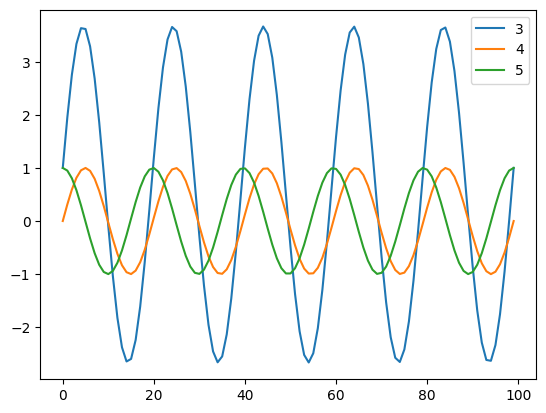

In [9]:
# Experiments in visualizing the generated training sequence
total_length = 100
# latent_size = 6
x_seq, y_seq = generate_training_sequence(total_length=100, latent_size=7)
plt.plot(y_seq[0:100,3], label= "3")
plt.plot(x_seq[0:100,4], label= "4")
plt.plot(x_seq[0:100,5], label= "5")
plt.legend()

In [10]:

sequence_length = 10  # Number of vectors in input sequence
inputs, targets = create_training_sequence_prediction(x_seq, sequence_length=sequence_length)
# Verify shapes
print("Inputs shape:", inputs.shape)   # Expected: [num_samples, sequence_length, latent_size]
print("Targets shape:", targets.shape) # Expected: [num_samples, latent_size]

Inputs shape: torch.Size([90, 10, 7])
Targets shape: torch.Size([90, 7])


## LSTM model for sequence prediction
Create an LSTM model for predicting a sequence. Train it. 

In [11]:
# This is the architecture created by chatgpt
class LSTMSequencePredictor(nn.Module):
    def __init__(self, latent_size, hidden_size, num_layers):
        super(LSTMSequencePredictor, self).__init__()
        self.lstm = nn.LSTM(latent_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, latent_size)

    def forward(self, x):
        # x: [batch_size, sequence_length, latent_size]
        out, _ = self.lstm(x)  # LSTM output shape: [batch_size, sequence_length, hidden_size]
        out = self.fc(out[:, -1, :])  # Take last time step output and pass through the fully connected layer
        return out  # Predicted next vector

In [12]:
# LSTM controller with residuals and three layers
# This code is written by Lotzi
class LSTMResidualController(nn.Module):
    def __init__(self, latent_size, hidden_size, output_size):
        super(LSTMResidualController, self).__init__()
        self.lstm_1 = nn.LSTM(latent_size, hidden_size, num_layers=1, batch_first=True)

        self.lstm_2 = nn.LSTM(hidden_size, hidden_size, num_layers=1, batch_first=True)

        self.lstm_3 = nn.LSTM(hidden_size, hidden_size, num_layers=1, batch_first=True)

        self.fc = nn.Linear(hidden_size, latent_size)

    def forward(self, x):
        # x: [batch_size, sequence_length, latent_size]
        out_1, _ = self.lstm_1(x)
        residual = out_1
        out_2, _ = self.lstm_2(out_1)
        out_2 = out_2 + residual
        residual = out_2
        out_3, _ = self.lstm_3(out_2)
        out_3 = out_3 + residual

        # LSTM output shape: [batch_size, sequence_length, hidden_size]
        out = self.fc(out_3[:, -1, :])  # Take last time step output and pass through the fully connected layer
        return out  # Predicted next vector

In [13]:

# Model Parameters
# Original
# latent_size = 7  # Dimension of each vector in the sequence
# hidden_size = 32  # Size of hidden state in LSTM
# num_layers = 2    # Number of LSTM layers

# Original
latent_size = 7  # Dimension of each vector in the sequence
hidden_size = 3  # Size of hidden state in LSTM
num_layers = 1    # Number of LSTM layers

# Simple model: Instantiate model, loss function, and optimizer
model = LSTMSequencePredictor(latent_size=latent_size, hidden_size=hidden_size, num_layers=num_layers)

# Residual model: Instantiate model, loss function, and optimizer
# model = LSTMResidualController(latent_size=latent_size, hidden_size=hidden_size, output_size = hidden_size)

criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create the training data
total_length = 100
x_seq, y_seq = generate_training_sequence(total_length=total_length, latent_size=latent_size)
inputs, targets = create_training_sequence_prediction(x_seq, sequence_length=sequence_length)
num_sequences = inputs.shape[0]
print(num_sequences)

90


In [14]:

# Training Loop
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    
    # Loop over each sequence in the batch
    for i in range(num_sequences):
        # Prepare input and target
        input_seq = inputs[i]
        target = targets[i]

        # Reshape for batch compatibility
        input_seq = input_seq.unsqueeze(0)  # Shape: [1, sequence_length, latent_size]
        target = target.unsqueeze(0)        # Shape: [1, latent_size]

        # Forward pass
        output = model(input_seq)
        loss = criterion(output, target)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 2 == 0: # was 0
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training complete.")

# FIXME: save the model
# FIXME: this should be saved into some experimental file name. 
filename_lstm = Config()["explorations"]["lstm_model_file"]
torch.save(model.state_dict(), filename_lstm)

Epoch [2/100], Loss: 0.3195
Epoch [4/100], Loss: 0.2905
Epoch [6/100], Loss: 0.2681
Epoch [8/100], Loss: 0.2468
Epoch [10/100], Loss: 0.2284
Epoch [12/100], Loss: 0.2107
Epoch [14/100], Loss: 0.1938
Epoch [16/100], Loss: 0.1795
Epoch [18/100], Loss: 0.1676
Epoch [20/100], Loss: 0.1573
Epoch [22/100], Loss: 0.1480
Epoch [24/100], Loss: 0.1389
Epoch [26/100], Loss: 0.1292
Epoch [28/100], Loss: 0.1189
Epoch [30/100], Loss: 0.1082
Epoch [32/100], Loss: 0.0972
Epoch [34/100], Loss: 0.0862
Epoch [36/100], Loss: 0.0756
Epoch [38/100], Loss: 0.0659
Epoch [40/100], Loss: 0.0571
Epoch [42/100], Loss: 0.0494
Epoch [44/100], Loss: 0.0429
Epoch [46/100], Loss: 0.0375
Epoch [48/100], Loss: 0.0330
Epoch [50/100], Loss: 0.0294
Epoch [52/100], Loss: 0.0264
Epoch [54/100], Loss: 0.0241
Epoch [56/100], Loss: 0.0222
Epoch [58/100], Loss: 0.0207
Epoch [60/100], Loss: 0.0194
Epoch [62/100], Loss: 0.0183
Epoch [64/100], Loss: 0.0174
Epoch [66/100], Loss: 0.0167
Epoch [68/100], Loss: 0.0160
Epoch [70/100], Lo

KeyError: 'explorations'

In [9]:
load_model = True
if load_model:
    model = LSTMSequencePredictor(latent_size=latent_size, hidden_size=hidden_size, num_layers=num_layers)
    filename_lstm = Config()["explorations"]["lstm_model_file"]
    model.load_state_dict(torch.load(filename_lstm))
# FIXME: load the model

KeyError: 'explorations'

## Evaluate the trained LSTM model

In [15]:
def model_step_by_step_prediction(model, sequence_length, latent_size):
    """Run a prediction where we are always predicting the next item from the previous 10 ground truth items"""
    start = 0
    result = np.zeros((sequence_length, latent_size))
    model.eval()
    with torch.no_grad():
        for i in range(0, total_length - sequence_length):
            input_seq = x_seq[start+i : start+ i + sequence_length]
            input_val = input_seq.unsqueeze(0)
            val = model(input_val)
            result = np.append(result, [val.squeeze(0).tolist()], axis=0) 
    return result

(100, 7)


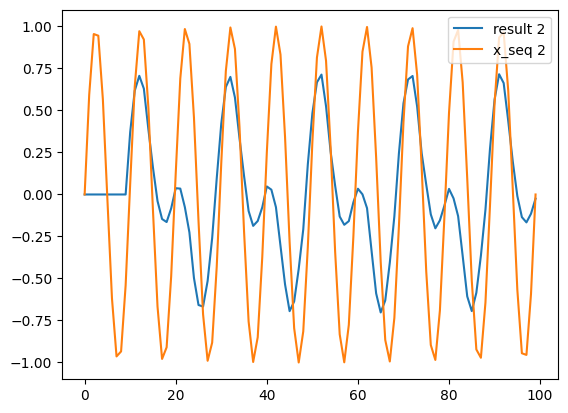

In [16]:


# Visualize the step by step prediction
result = model_step_by_step_prediction(model, sequence_length, latent_size)
print(result.shape)

channel = 2
plt.plot(result[0:100,channel], label=f"result {channel}")
plt.plot(x_seq[0:100,channel], label = f"x_seq {channel}")
plt.legend()


In [17]:
# Run autoregressive prediction (use the prediction as the next data)
def model_autoregressive_prediction(model, x_seq, sequence_length):
    """Run an autoregressive prediction where we are always predicting the next item from the previous 10 ground truth items"""
    start = 0
    result = np.zeros((sequence_length, latent_size))
    input_seq = x_seq[start : start + sequence_length]
    with torch.no_grad():
        for i in range(0, total_length - sequence_length):
            model.eval()            
            input_val = input_seq.unsqueeze(0)
            val = model(input_val)
            next_item = val.squeeze(0).tolist()
            result = np.append(result, [val.squeeze(0).tolist()], axis=0) 
            input_seq = input_seq[1: sequence_length]
            input_seq= torch.cat((input_seq, val))
    #print(result)
    return np.array(result)

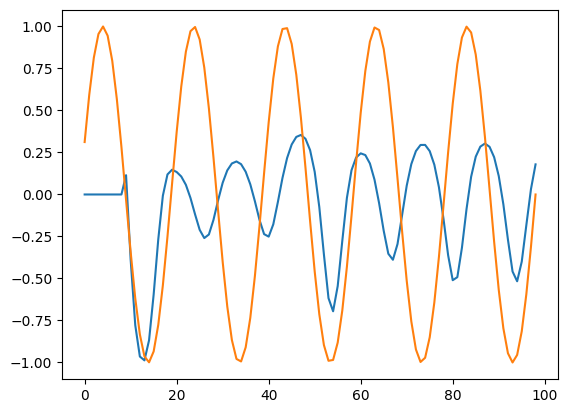

In [18]:
# Visualize the autoregressive prediction
# Calculate the error of the autoregressive prediction
# Visualize the step by step prediction
result = model_autoregressive_prediction(model, x_seq, sequence_length)
channel = 4
plt.plot(result[1:100,channel])
plt.plot(x_seq[1:100,channel])

## Training with an output which is not prediction

Training an LSTM with an output that is not a prediction of a string, but has a different dimensionality. 

In [19]:
# This is the architecture created by chatgpt
class LSTMXYPredictor(nn.Module):
    def __init__(self, latent_size, hidden_size, output_size, num_layers):
        super(LSTMXYPredictor, self).__init__()
        self.lstm = nn.LSTM(latent_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: [batch_size, sequence_length, latent_size]
        out, _ = self.lstm(x)  # LSTM output shape: [batch_size, sequence_length, hidden_size]
        out = self.fc(out[:, -1, :])  # Take last time step output and pass through the fully connected layer
        return out  # Predicted next vector

In [20]:
# Model Parameters
# Original
latent_size = 7  # Dimension of each vector in the sequence
hidden_size = 32  # Size of hidden state in LSTM
num_layers = 2    # Number of LSTM layers

# Modified
# latent_size = 7  # Dimension of each vector in the sequence
# hidden_size = 3  # Size of hidden state in LSTM
# num_layers = 1    # Number of LSTM layers
output_size = 5

# Instantiate model, loss function, and optimizer
model = LSTMXYPredictor(latent_size=latent_size, hidden_size=hidden_size, output_size = output_size, num_layers=num_layers)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create the training data
total_length = 100
x_seq, y_seq = generate_training_sequence(total_length=total_length, latent_size=latent_size, y_size=output_size)
inputs, targets = create_training_sequence_xy(x_seq, y_seq, sequence_length=sequence_length)
num_sequences = inputs.shape[0]
print(inputs.shape)
print(targets.shape)

torch.Size([90, 10, 7])
torch.Size([90, 5])


In [21]:
# Training Loop
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    
    # Loop over each sequence in the batch
    for i in range(num_sequences):
        # Prepare input and target
        input_seq = inputs[i]
        target = targets[i]

        # Reshape for batch compatibility
        input_seq = input_seq.unsqueeze(0)  # Shape: [1, sequence_length, latent_size]
        target = target.unsqueeze(0)        # Shape: [1, latent_size]

        # Forward pass
        output = model(input_seq)
        loss = criterion(output, target)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 2 == 0: # was 0
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training complete.")

# FIXME: save the model
filename_lstm = Config()["controller"]["lstm_model_file"]
torch.save(model.state_dict(), filename_lstm+".2")

Epoch [2/100], Loss: 0.2208
Epoch [4/100], Loss: 0.3305
Epoch [6/100], Loss: 0.0669
Epoch [8/100], Loss: 0.0290
Epoch [10/100], Loss: 0.0171
Epoch [12/100], Loss: 0.0301
Epoch [14/100], Loss: 0.0205
Epoch [16/100], Loss: 0.0598
Epoch [18/100], Loss: 0.0212
Epoch [20/100], Loss: 0.0330
Epoch [22/100], Loss: 0.0537
Epoch [24/100], Loss: 0.0261
Epoch [26/100], Loss: 0.0229
Epoch [28/100], Loss: 0.0289
Epoch [30/100], Loss: 0.0248
Epoch [32/100], Loss: 0.0347
Epoch [34/100], Loss: 0.0690
Epoch [36/100], Loss: 0.0487
Epoch [38/100], Loss: 0.0291
Epoch [40/100], Loss: 0.0299
Epoch [42/100], Loss: 0.0351
Epoch [44/100], Loss: 0.0563
Epoch [46/100], Loss: 0.0510
Epoch [48/100], Loss: 0.0361
Epoch [50/100], Loss: 0.0347
Epoch [52/100], Loss: 0.0378
Epoch [54/100], Loss: 0.0787
Epoch [56/100], Loss: 0.0431
Epoch [58/100], Loss: 0.0363
Epoch [60/100], Loss: 0.0445
Epoch [62/100], Loss: 0.0591
Epoch [64/100], Loss: 0.0604
Epoch [66/100], Loss: 0.0400
Epoch [68/100], Loss: 0.0437
Epoch [70/100], Lo

KeyError: 'controller'

In [22]:
# FIXME: not implemented yet

def model_xy_prediction(model, x_seq, sequence_length, latent_size, output_size):
    """Model the XY prediction"""
    start = 0
    result = np.zeros((sequence_length, output_size))
    model.eval()
    with torch.no_grad():
        for i in range(0, total_length - sequence_length):
            input_seq = x_seq[start+i : start+ i + sequence_length]
            input_val = input_seq.unsqueeze(0)
            val = model(input_val)
            result = np.append(result, [val.squeeze(0).tolist()], axis=0) 
    return result

(100, 5)


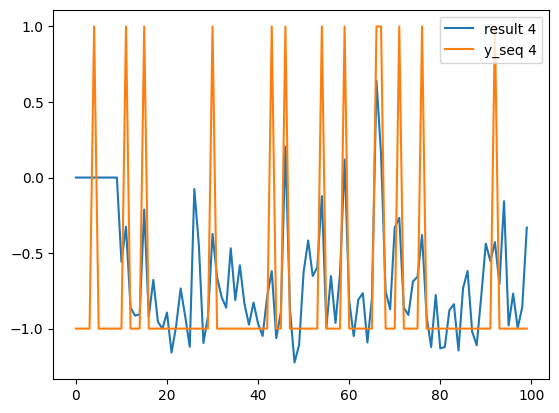

In [23]:
# Visualize the step by step prediction
result = model_xy_prediction(model, x_seq, sequence_length, latent_size, output_size)
print(result.shape)

channel = 4
plt.plot(result[0:100,channel], label=f"result {channel}")
plt.plot(y_seq[0:100,channel], label = f"y_seq {channel}")
plt.legend()
